In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from numpy import logical_and as land
from numpy import logical_or as lor
from numpy import invert as lin

In [2]:
def get_theta(mu, cov, rho):
    '''
    Returns explicit threshold theta for a given percentage rho of anomalies in 
    data distributed as a Gaussian with mean mu and covariance matrix cov. 
    
    Parameters
        mu    mean of Gaussian distribution
        cov   covariance matrix of Gaussian distribution
        rho   percentage of anomalies, which must be between 0 and 100 inclusive
    '''
    # generate random variables (data)
    X = multivariate_normal.rvs(mean=mu, cov=cov, size=5000000)
    # center data (normalize) (for x_i - mu)
    Z = X - mu
    # calculate the mahalanobis distance
    # d2M (xi, ˆμ) = (xi − ˆμ)T ˆΣ−1(xi − ˆμ)
    d = np.sqrt(np.sum(Z.dot(inv(cov)) * Z, axis=1))
    # thetha = 
    return np.percentile(d, 100-rho) 

# get_theta([0, 0], [[1, 0], [0, 1]], 5)

In [3]:
# styling and fig siz
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']= 16, 10  

In [4]:
# utility functions for plotting etc
def gen_data(mu, cov, n=1000):
    '''
    generate bivariate gaussian data
    
    mu mean of the gaussian distribution
    cov covariance matrix
    n size (number of points)
    '''
    return multivariate_normal.rvs(cov=cov, mean=mu, size=n)

def plt_points(data, outliers_indices=None):
    '''
    plot 2dim data
    
    data data plotted blue 
    outliers_indices if is not None, indices which are True will be plotted red
    '''
    
    outliers = None
    
    if outliers_indices is not None:
        outliers = data[outliers_indices, :]
        data = data[lin(outliers_indices), :]
    
    # Plotting the generated samples
    plt.plot(data[:,0], data[:,1], 'o', c='blue',
             markeredgewidth = 0.5,
             markeredgecolor = 'black')
    
    if outliers is not None:
        plt.plot(outliers[:,0], outliers[:,1], 'o', c='red',
                 markeredgewidth = 0.5,
                 markeredgecolor = 'black')
        
    # plt.title('covariance of distribution')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.axis('equal')
     
    plt.show()
    
def plt_pdf3d(mu, cov):
    '''
    plot the density function from a bivariate gaussian distribution 3d
    
    mu mean
    cov covariance matrix
    '''
    distr = multivariate_normal(cov=cov, mean=mu)
     
    # Generating a meshgrid complacent with
    # the 3-sigma boundary
    mean_1, mean_2 = mu[0], mu[1]
    sigma_1, sigma_2 = cov[0,0], cov[1,1]
     
    x = np.linspace(-3*sigma_1, 3*sigma_1, num=100)
    y = np.linspace(-3*sigma_2, 3*sigma_2, num=100)
    X, Y = np.meshgrid(x, y)
     
    # Generating the density function
    # for each point in the meshgrid
    pdf = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])
     
    # Plotting the density function values
    ax = plt.figure().add_subplot(111, projection = '3d')
    ax.plot_surface(X, Y, pdf, cmap = 'viridis')
    plt.xlabel("x1")
    plt.ylabel("x2")
    ax.axes.zaxis.set_ticks([])
    
    plt.show()
    
    

def plt_pdf(mu, cov):
    '''
    plot the density function from a bivariate gaussian distribution
    
    mu mean
    cov covariance matrix
    '''
    distr = multivariate_normal(cov=cov, mean=mu)
    
    # Generating a meshgrid complacent with
    # the 3-sigma boundary
    mean_1, mean_2 = mu[0], mu[1]
    sigma_1, sigma_2 = cov[0,0], cov[1,1]
     
    x = np.linspace(-3*sigma_1, 3*sigma_1, num=100)
    y = np.linspace(-3*sigma_2, 3*sigma_2, num=100)
    X, Y = np.meshgrid(x, y)
     
    # Generating the density function
    # for each point in the meshgrid
    pdf = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])
            
            
    plt.contourf(X, Y, pdf, cmap='viridis')
    plt.xlabel("x1")
    plt.ylabel("x2")
    
    plt.show()
    

# Assignment
1. Sample a data set D of size n from N (x; μ, Σ). Fix a percentage ρ.
2. Use the function get_theta(mu, cov, rho) provided by the notebook to
obtain an explicit threshold θ given the percentage ρ. Note that θ is part
of the ground-truth and therefore considered as unknown.
3. Determine the true anomalies of D. For this, use the explicit threshold θ
together with the Mahalanobis distance d∗
M defined by the true μ and Σ.
4. Use the data D to estimate μ and Σ. Construct the Mahalanobis distance
dM defined by the estimates ˆμ and ˆΣ.
5. Predict the anomalies of D using the Mahalanobis distance dM and Eu-
clidean distance dE . Anomalies are the ρ percent points xi ∈ D farthest
from ˆμ (do not use θ). Assess precision and recall of both detectors.

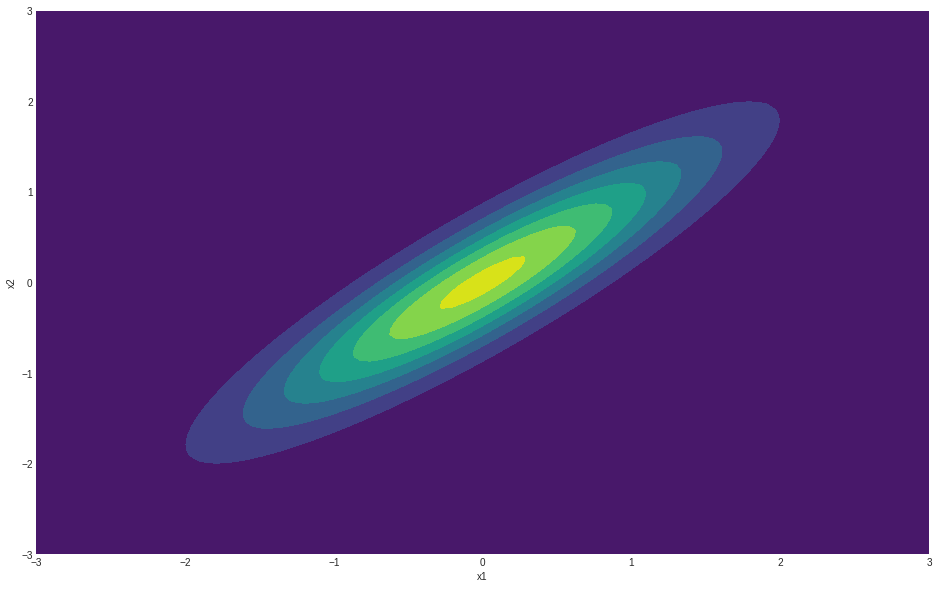

In [5]:
# fixate groundtruth mean and covariance matrix for the bivariate gaussian distribution
# '_T' nominator stands for groundtruth variable
# '_E' nominator stands for estimated variable
mu_T = np.array([0, 0])  # mean at (0, 0)
covariance = .9
sigma_T = np.array([[1, covariance], [covariance, 1]])  # covariance matrix
rho = 5  # preset percentage of outliers
size = 5000  # number of data points    

# plot true pdf
plt_pdf(mu_T, sigma_T)

In [6]:
# 1. generate dataset (RandomVariableS)
D = multivariate_normal.rvs(mean=mu_T, cov=sigma_T, size=size)

In [7]:
# 2. use get_theta to get the 'groundtruth' explicit treshold theta
theta = get_theta(mu_T, sigma_T, rho)

In [8]:
# 3. determine subset of true anomalies of dataset D
# start by calculating the mahalanobis distance of each point from the mean
Z_T = D - mu_T
d_m_T = np.sqrt(np.sum(Z_T.dot(inv(sigma_T)) * Z_T, axis=1))

In [9]:
# filter out values (indices) over the groundtruth threshold theta (True / False array)
I_T = d_m_T > theta  # indices of true anomalies with mahalanobis distance
# print percentage of as true determined inices
I_T.sum() / len(I_T)

0.0534

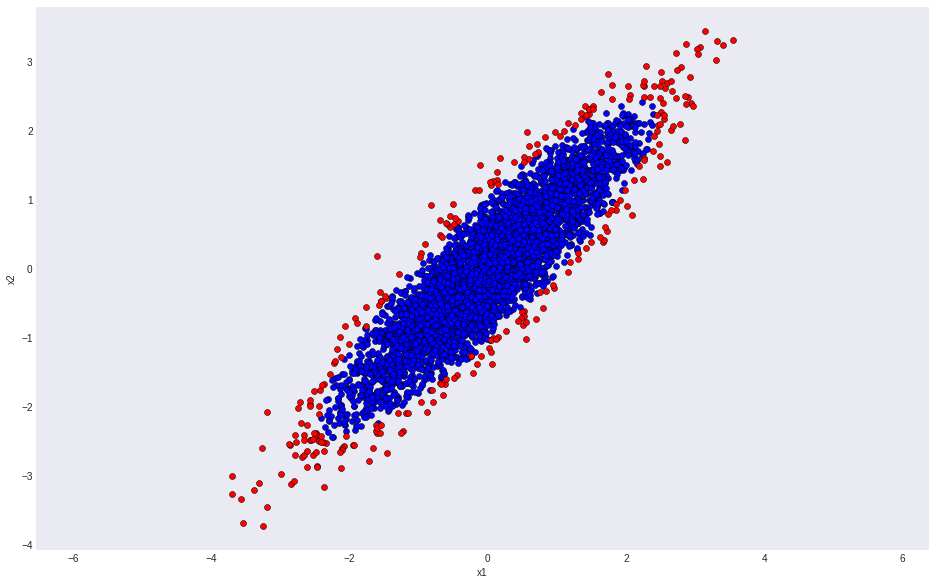

In [10]:
# plot dataset with true anomalies
plt_points(D, I_T)

In [11]:
# 4. Use the data D to estimate mu and sigma
mu_E = D.mean(axis=0)
sigma_E = np.cov(D.T) 

In [12]:
# Construct the Mahalanobis distance d_m_E defined by the estimates mu_E and sigma_E
Z_E = D - mu_E
d_m_E = np.sqrt(np.sum(Z_E.dot(inv(sigma_E)) * Z_E, axis=1))

In [13]:
# construct euklidian distance d_e_E in the same manner (with mu_E and sigma_E)
d_e_E = np.sqrt(np.sum(Z_E ** 2, axis=1)) 

In [14]:
print(d_e_E)
print(d_m_E)

[0.26479471 0.9743083  1.42121449 ... 1.39253837 1.09828447 0.8552774 ]
[0.35072084 1.50480046 1.13084476 ... 1.6526423  1.63209911 0.73542134]


In [15]:
# 5. predict anomalies with estimated eucilidian (d_e_E) and mahalanobis distance (d_m_E)
# create list of indices (True / False array) (on axis 0 of dataset)
# estimated thresholds (eta) are rho percent points with the farthest distance from mu_E
eta_m = np.percentile(d_m_E, 100-rho)
eta_e = np.percentile(d_e_E, 100-rho) 

I_m_E = d_m_E > eta_m
I_e_E = d_e_E > eta_e 

assert len(I_m_E[I_m_E]) / len(I_m_E) == rho * .01

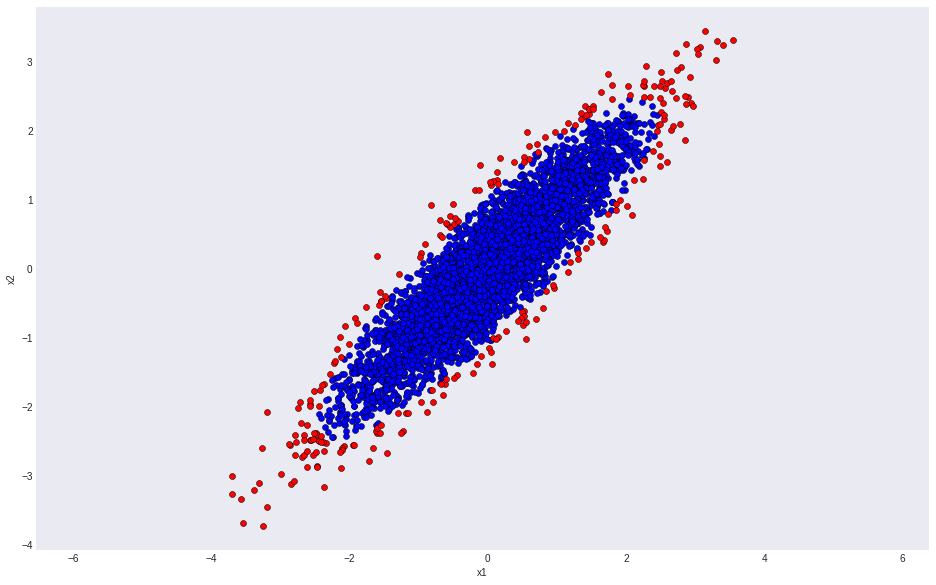

In [16]:
# plot data with estimated outliers from mahalanobis distance
plt_points(D, I_m_E)

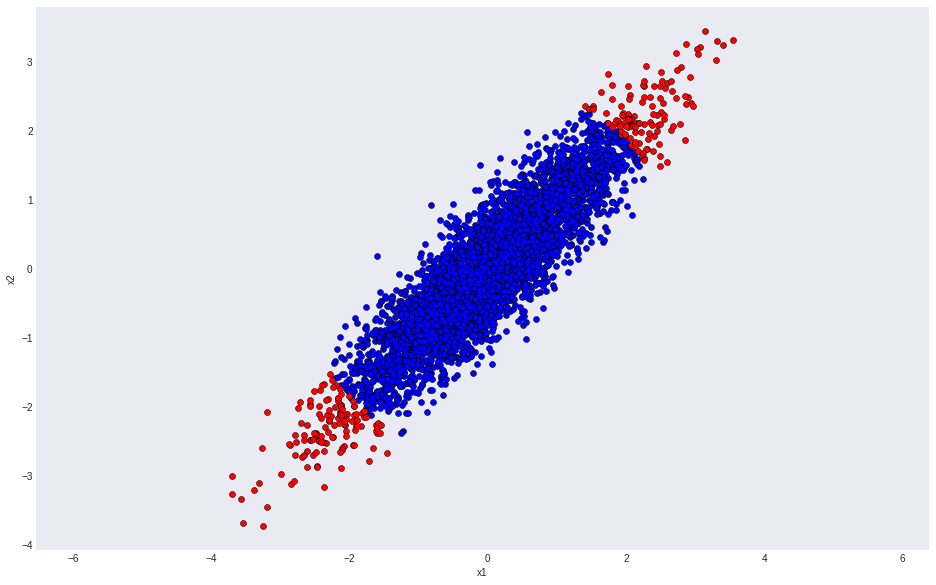

In [17]:
# plot data with estimated outliers from euklidian distance
plt_points(D, I_e_E)

# Precision & Recall:
Performance metrics for anomaly detection are precision `tp/(tp + fp)` and recall `tp/(tp + fn)`, where
- tp is the number of true positives, that is the number of points that are
correctly predicted as anomalies
- fp is the number of false positives, that is the number of normal points
that are falsely predicted as anomalies
- fn is the number of false negatives, that is the number of anomalies that
are falsely predicted as normal points

In [18]:
# Comparison:
# Assess precision and recall of both detectors. (5)
# calculate tp, fp and fn for euklidian distance and for mahalanobis distance

# np.logical_and(I_m_T, I_m_E) [here: land] creates a logical AND mask over the two boolean arrays etc.
# (I_m_T * I_m_E)
tp_m = land(I_T, I_m_E).sum()
tp_e = land(I_T, I_e_E).sum()

fp_m = land(lin(I_T), I_m_E).sum()
fp_e = land(lin(I_T), I_e_E).sum()

fn_m = land(I_T, lin(I_m_E)).sum()
fn_e = land(I_T, lin(I_e_E)).sum()

# precisions and recalls mahalanobis (m) and euklidian (e) distance
precision_m = tp_m / (tp_m + fp_m) 
recall_m = tp_m / (tp_m + fn_m)

precision_e = tp_e / (tp_e + fp_e)
recall_e = tp_e / (tp_e + fn_e)

print(f'precision euklidian : {precision_e}')
print(f'precision mahalanobis : {precision_m}')
print(f'recall euklidian : {recall_e}')
print(f'recall mahalanobis : {recall_m}')

precision euklidian : 0.556
precision mahalanobis : 1.0
recall euklidian : 0.5205992509363296
recall mahalanobis : 0.9363295880149812
